# Tori 

## Setup

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from les import les_desc_comp, les_dist_comp
from comparisons import CompareIMD, CompareIMDOurApproach, CompareTDA, CompareGS, CompareGW
import pandas as pd 
import seaborn as sns 

## Simulate Tori 

In [49]:
# Simulation parameters:
N = 1000  # Number of samples - reduced from N=3000 for faster computation times
ITER_NUM = 10  # Number of trials to average on
R1 = 10  # Major radius
R2 = 3  # Minor/middle radius in 2D/3D
R3 = 1  # Minor radius in 3D
NOISE_VAR = 1  # STD of added noise to the tori data
R_RATIOS = np.arange(0.2, 2.01, 0.2)  # Radius ratio (c parameter)
DICT_KEYS = ['t2D_2DSc', 't2D_3D', 't2D_3DSc', 't3D_2DSc', 't3D_3DSc']

In [50]:
def tori_2d_gen(c, NOISE_VAR=0.01):
    ang1, ang2, ang3 = 2 * np.pi * np.random.rand(N), 2 * np.pi * np.random.rand(N), 2 * np.pi * np.random.rand(N)
    tor2d = np.concatenate(([(R1 + c * R2 * np.cos(ang2)) * np.cos(ang1)],
                            [(R1 + c * R2 * np.cos(ang2)) * np.sin(ang1)],
                            [c * R2 * np.sin(ang2)]),
                           axis=0)
    tor2d += NOISE_VAR * np.random.randn(3, N)
    return tor2d


def tori_3d_gen(c, NOISE_VAR=0.01):
    ang1, ang2, ang3 = 2 * np.pi * np.random.rand(N), 2 * np.pi * np.random.rand(N), 2 * np.pi * np.random.rand(N)
    tor3d = np.concatenate(([(R1 + (R2 + c * R3 * np.cos(ang3)) * np.cos(ang2)) * np.cos(ang1)],
                            [(R1 + (R2 + c * R3 * np.cos(ang3)) * np.cos(ang2)) * np.sin(ang1)],
                            [(R2 + c * R3 * np.cos(ang3)) * np.sin(ang2)],
                            [c * R3 * np.sin(ang3)]),
                           axis=0)
    tor3d += NOISE_VAR * np.random.randn(4, N)
    return tor3d

## LES Hyperparameter 

In [51]:
# LES hyperparameter
GAMMA = 1e-8  # Kernel regularization parameter
SIGMA = 2  # Kernel scale
NEV = 200  # Number of eigenvalues to estimate

## Distance Algo

In [55]:
# ========================== Comparisons: ==========================
# List of algorithms to compare with. Possible algorithms: 'imd_ours', 'imd', 'tda', 'gs', 'gw'
ALGS2COMPARE = ['imd_ours']  # ['imd_ours', 'imd', 'gs', 'gw', 'tda']

# ALG_CLASS = {'imd': CompareIMD,
#              'imd_ours': CompareIMDOurApproach,
#              'tda': CompareTDA,
#              'gs': CompareGS,
#              'gw': CompareGW,
#              }

ALG_CLASS = {'imd': CompareIMD,
             'imd_ours': CompareIMDOurApproach,
             }



# Initialize the classes that compute the compared algorithms
algs_dists = {}
for alg in ALGS2COMPARE:
    alg = alg.lower()
    if alg == 'tda':
        algs_dists['tda_H0'] = ALG_CLASS[alg](0, ITER_NUM, R_RATIOS, DICT_KEYS)
        algs_dists['tda_H1'] = ALG_CLASS[alg](1, ITER_NUM, R_RATIOS, DICT_KEYS)
        algs_dists['tda_H2'] = ALG_CLASS[alg](2, ITER_NUM, R_RATIOS, DICT_KEYS)
    elif alg == 'imd_ours':
        algs_dists[alg] = ALG_CLASS[alg](GAMMA, ITER_NUM, R_RATIOS, DICT_KEYS)
    else:
        algs_dists[alg] = ALG_CLASS[alg](ITER_NUM, R_RATIOS, DICT_KEYS)

In [56]:
R_RATIOS

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

Computing radius ratio c = 0.2
Computing radius ratio c = 0.4
Computing radius ratio c = 0.6
Computing radius ratio c = 0.8
Computing radius ratio c = 1.0
Computing radius ratio c = 1.2
Computing radius ratio c = 1.4
Computing radius ratio c = 1.6
Computing radius ratio c = 1.8
Computing radius ratio c = 2.0


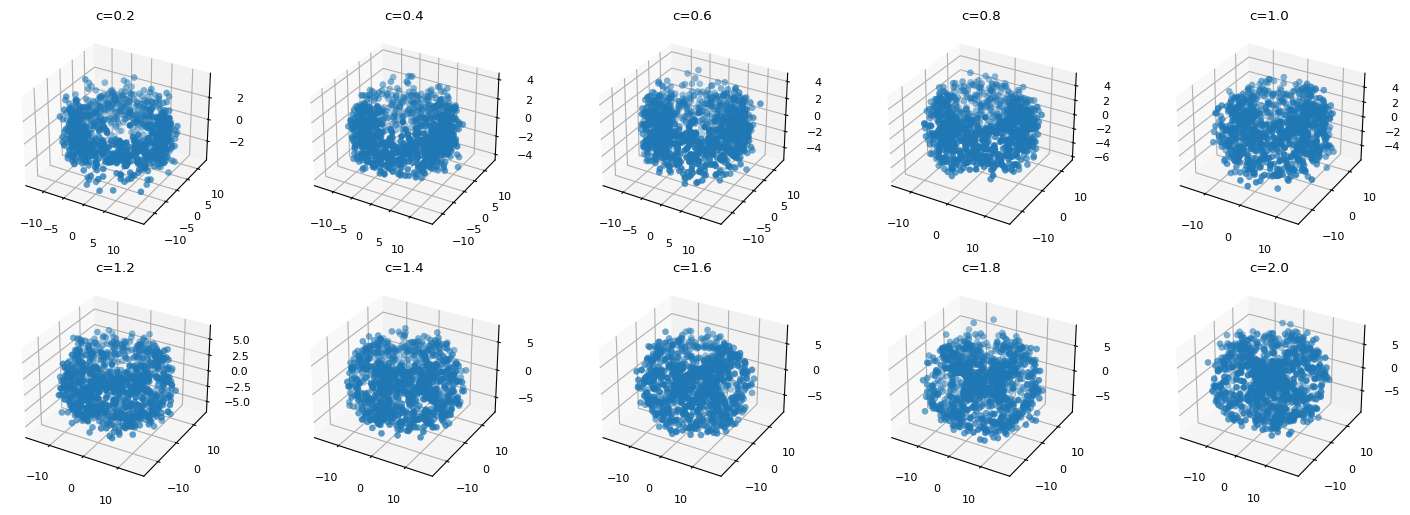

In [58]:

fig = plt.figure(figsize=(18,6))

for i, r_ratio in enumerate(R_RATIOS):
    ax = fig.add_subplot(2, len(R_RATIOS)//2, i+1, projection='3d')
    print(f'Computing radius ratio c = {r_ratio:.1f}')
    data_2d_tor_sc = tori_2d_gen(r_ratio,NOISE_VAR=NOISE_VAR)
    ax.scatter(data_2d_tor_sc[0],data_2d_tor_sc[1],data_2d_tor_sc[2])
    ax.set_title(f"c={r_ratio:.1f}")
    

plt.savefig('Tori_noise_100.jpg')
plt.show()

In [59]:
# ========= Initializations and tori equation definitions =========
les_dist = {key: np.zeros((ITER_NUM, len(R_RATIOS))) for key in DICT_KEYS}

for ite in range(ITER_NUM):
    print(f'Running iteration number {ite}')

    for i, r_ratio in enumerate(R_RATIOS):
        print(f'Computing radius ratio c = {r_ratio:.1f}')

        # -------------- Generate tori data --------------
        data_2d_tor = tori_2d_gen(1, NOISE_VAR=NOISE_VAR)
        data_2d_tor_sc = tori_2d_gen(r_ratio, NOISE_VAR=NOISE_VAR)
        data_3d_tor = tori_3d_gen(1,NOISE_VAR=NOISE_VAR)
        data_3d_tor_sc = tori_3d_gen(r_ratio,NOISE_VAR=NOISE_VAR)

        # ---- Computing dataset descriptors and distances ----
        print('Computing LES descriptors and distances')
        les_desc_2d_tor = les_desc_comp(data_2d_tor.T, SIGMA, NEV, GAMMA)
        les_desc_2d_tor_sc = les_desc_comp(data_2d_tor_sc.T, SIGMA, NEV, GAMMA)
        les_desc_3d_tor = les_desc_comp(data_3d_tor.T, SIGMA, NEV, GAMMA)
        les_desc_3d_tor_sc = les_desc_comp(data_3d_tor_sc.T, SIGMA, NEV, GAMMA)

        les_dist['t2D_2DSc'][ite, i] = les_dist_comp(les_desc_2d_tor, les_desc_2d_tor_sc)
        les_dist['t2D_3D'][ite, i] = les_dist_comp(les_desc_2d_tor, les_desc_3d_tor)
        les_dist['t2D_3DSc'][ite, i] = les_dist_comp(les_desc_2d_tor, les_desc_3d_tor_sc)
        les_dist['t3D_2DSc'][ite, i] = les_dist_comp(les_desc_3d_tor, les_desc_2d_tor_sc)
        les_dist['t3D_3DSc'][ite, i] = les_dist_comp(les_desc_3d_tor, les_desc_3d_tor_sc)

        for alg in algs_dists:
            print('Computing ' + alg.upper() + ' descriptors')
            if alg == 'imd_ours':
                algs_dists[alg].comp_all_tori_dists(ite, i, les_desc_2d_tor, les_desc_2d_tor_sc, les_desc_3d_tor,
                                                    les_desc_3d_tor_sc)
            else:
                algs_dists[alg].comp_all_tori_dists(ite, i, data_2d_tor.T, data_2d_tor_sc.T, data_3d_tor.T,
                                                    data_3d_tor_sc.T)


Running iteration number 0
Computing radius ratio c = 0.2
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 0.4
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 0.6
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 0.8
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 1.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 1.2
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 1.4
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 1.6
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 1.8
Computing LES descriptors and distances
Computing IMD_OURS descriptors
Computing radius ratio c = 2.0
Computing LES descriptor

/tmp/ipykernel_11816/334862835.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


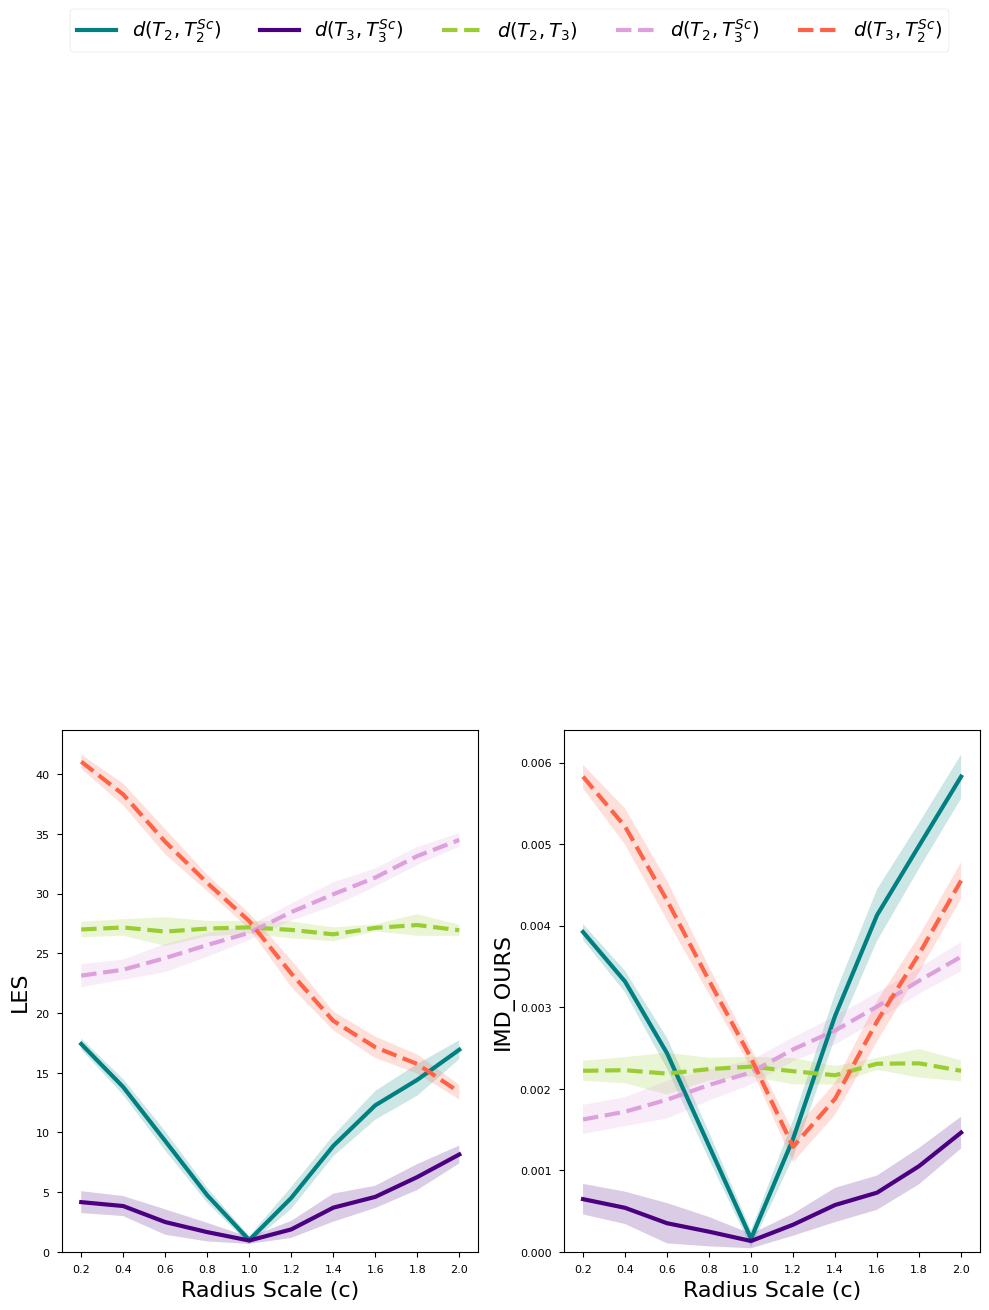

In [60]:
# ========================== Plot display ==========================
plt.style.use('seaborn-paper')
line_width = 3
alpha_val = 0.2


def create_distance_plt(var, ylabel='', xlabel=''):
    plt.plot(R_RATIOS, np.mean(var['t2D_2DSc'], axis=0), '-', color='teal', linewidth=line_width,
             label="$d(T_{2},T_{2}^{Sc})$")
    x, y, err = R_RATIOS, np.mean(var['t2D_2DSc'], axis=0), np.std(var['t2D_2DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='teal', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t3D_3DSc'], axis=0), '-', color='indigo', linewidth=line_width,
             label="$d(T_{3},T_{3}^{Sc})$")
    y, err = np.mean(var['t3D_3DSc'], axis=0), np.std(var['t3D_3DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='indigo', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t2D_3D'], axis=0), '--', color='yellowgreen', linewidth=line_width,
             label="$d(T_{2},T_{3})$")
    y, err = np.mean(var['t2D_3D'], axis=0), np.std(var['t2D_3D'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='yellowgreen', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t2D_3DSc'], axis=0), '--', color='plum', linewidth=line_width,
             label="$d(T_{2},T_{3}^{Sc})$")
    y, err = np.mean(var['t2D_3DSc'], axis=0), np.std(var['t2D_3DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='plum', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t3D_2DSc'], axis=0), '--', color='tomato', linewidth=line_width,
             label="$d(T_{3},T_{2}^{Sc})$")
    y, err = np.mean(var['t3D_2DSc'], axis=0), np.std(var['t3D_2DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='tomato', linewidth=0)

    plt.ylim(bottom=0)
    plt.xticks(R_RATIOS, [ f"{r_ratio:.1f}" for r_ratio in R_RATIOS])
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)


anum = len(algs_dists) + 1
if anum <= 4:
    sbplt_rc = [1, anum]
else:
    sbplt_rc = [2, int(np.ceil(anum/2))]

fig = plt.figure(figsize=[10, 6])
plt.subplot(sbplt_rc[0], sbplt_rc[1], 1)
create_distance_plt(les_dist, ylabel='LES', xlabel='Radius Scale (c)')
for i, alg in enumerate(algs_dists):
    plt.subplot(sbplt_rc[0], sbplt_rc[1], i+2)
    create_distance_plt(algs_dists[alg].all_distances, ylabel=alg.upper(), xlabel='Radius Scale (c)')

# plt.legend(framealpha=1, frameon=True, handlelength=2.5)
fig.tight_layout()
legendid = plt.legend(framealpha=1, frameon=True, loc='upper right', bbox_to_anchor=(0.95, 2.4), fontsize=14, labelspacing=0.1, handlelength=2, ncol=5)
plt.savefig('Tori_dist_noise_100.jpg')
plt.show()

## Pairs of Same Geomtry at different noise level 

In [227]:
les_dist['t2D_2DSc'][ite, i]

22.886365922075644

Computing radius ratio c = 2.0
Computing radius ratio c = 2.0
Computing radius ratio c = 2.0
Computing radius ratio c = 2.0
Computing radius ratio c = 2.0
Computing radius ratio c = 2.0


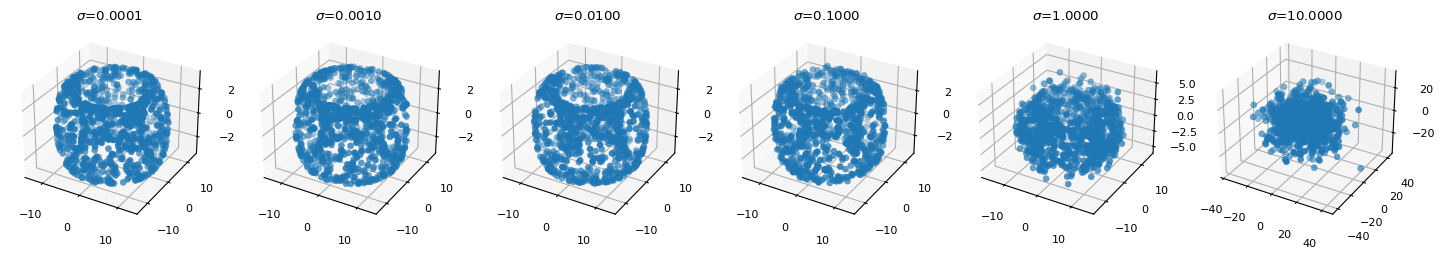

In [228]:
fig = plt.figure(figsize=(18,6))

noise_vars=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

for i, noise_var in enumerate(noise_vars):
    ax = fig.add_subplot(1, len(noise_vars), i+1, projection='3d')
    print(f'Computing radius ratio c = {r_ratio:.1f}')
    data_2d_tor_sc = tori_2d_gen(1,NOISE_VAR=noise_var)
    ax.scatter(data_2d_tor_sc[0],data_2d_tor_sc[1],data_2d_tor_sc[2])
    ax.set_title(f"$\sigma$={noise_var:.4f}")
    

plt.savefig('Tori_noise_vars.jpg')
plt.show()

In [229]:
DICT_KEYS = ['t2D_2D', 't3D_3D']
les_dist = {key: np.zeros((ITER_NUM, len(noise_vars))) for key in DICT_KEYS}

In [221]:
# ========= Initializations and tori equation definitions =========
les_dist = {key: np.zeros((ITER_NUM, len(noise_vars))) for key in DICT_KEYS}
imd_ours = {key: np.zeros((ITER_NUM, len(noise_vars))) for key in DICT_KEYS}

for ite in range(ITER_NUM):
    print(f'Running iteration number {ite}')

    for i, noise_var in enumerate(noise_vars):
        print(f'Computing radius ratio noise_vars = {noise_var:.1f}')

        # -------------- Generate tori data --------------
        data_2d_tor_a= tori_2d_gen(1,NOISE_VAR=noise_var)
        data_2d_tor_b = tori_2d_gen(1,NOISE_VAR=noise_var)
        
        data_3d_tor_a = tori_3d_gen(1,NOISE_VAR=noise_var)
        data_3d_tor_b = tori_3d_gen(1,NOISE_VAR=noise_var)
        
        # ---- Computing dataset descriptors and distances ----
        print('Computing LES descriptors and distances')
        les_desc_2d_tor_a = les_desc_comp(data_2d_tor_a.T, SIGMA, NEV, GAMMA)
        les_desc_2d_tor_b = les_desc_comp(data_2d_tor_b.T, SIGMA, NEV, GAMMA)
        
        les_desc_3d_tor_a = les_desc_comp(data_3d_tor_a.T, SIGMA, NEV, GAMMA)
        les_desc_3d_tor_b = les_desc_comp(data_3d_tor_b.T, SIGMA, NEV, GAMMA)

        les_dist['t2D_2D'][ite, i] = les_dist_comp(les_desc_2d_tor_a, les_desc_2d_tor_b)
        les_dist['t3D_3D'][ite, i] = les_dist_comp(les_desc_3d_tor_a, les_desc_3d_tor_b)
        
        # ---- Computing dataset descriptors and distances ----
        print('Computing IMD_OURS descriptors and distances')
        ALG_DIST = CompareIMDOurApproach(GAMMA, ITER_NUM, R_RATIOS, DICT_KEYS)
        
        imd_ours_desc_2d_tor_a = ALG_DIST._comp_desc(les_desc_2d_tor_a)
        imd_ours_desc_2d_tor_b = ALG_DIST._comp_desc(les_desc_2d_tor_b)
        
        imd_ours_desc_3d_tor_a = ALG_DIST._comp_desc(les_desc_3d_tor_a)
        imd_ours_desc_3d_tor_b = ALG_DIST._comp_desc(les_desc_3d_tor_b)

        imd_ours['t2D_2D'][ite, i] = ALG_DIST._comp_dist(imd_ours_desc_2d_tor_a, imd_ours_desc_2d_tor_b)
        imd_ours['t3D_3D'][ite, i] = ALG_DIST._comp_dist(imd_ours_desc_3d_tor_a, imd_ours_desc_3d_tor_b)



Running iteration number 0
Computing radius ratio noise_vars = 0.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing radius ratio noise_vars = 0.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing radius ratio noise_vars = 0.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing radius ratio noise_vars = 0.1
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing radius ratio noise_vars = 1.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing radius ratio noise_vars = 10.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Running iteration number 1
Computing radius ratio noise_vars = 0.0
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing radius ratio noise_vars = 0.0
Computing LES descriptors and 

In [222]:
result = imd_ours
# imd_ours, les_dist

dist_type_col = [] 
iter_col = [] 
noise_vars_col = [] 
dist_col = []
for dist_type in result.keys():
    dist_type_col.extend([dist_type] * (ITER_NUM * len(noise_vars)))
    for i in range(ITER_NUM): 
        iter_col.extend([i]*len(noise_vars))
        noise_vars_col.extend(noise_vars)
        dist_col.extend(result[dist_type][i])
        
result_df = pd.DataFrame(zip(dist_type_col, iter_col, noise_vars_col, dist_col), columns=["type", 'iter', 'noise_var', 'dist']) 

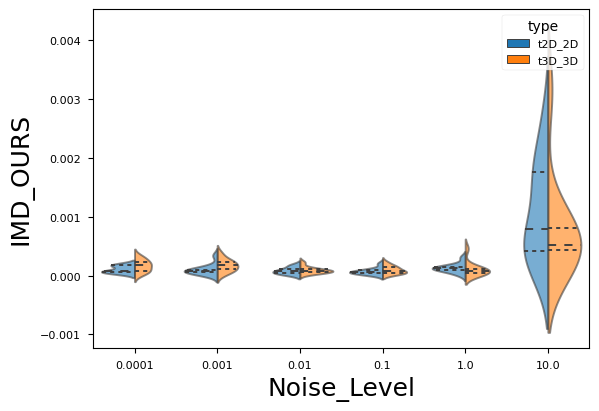

In [226]:
ax = sns.violinplot(data=result_df, x="noise_var", y="dist", hue="type", split=True, gap=.1, inner="quart", saturation=1)
plt.setp(ax.collections, alpha=.6)
plt.ylabel("IMD_OURS", fontsize=18)
plt.xlabel("Noise_Level", fontsize=18)
plt.savefig("IMD_OURS_noise.jpg")

In [126]:
def random_projection(data_dim, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data_dim)
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data_dim))
    # return np.dot(projection_matrix, data)
    return projection_matrix


In [132]:
data_2d_tor= tori_2d_gen(1)

proj_matrix = random_projection(4, 10)

Embed Dim d = 5
Embed Dim d = 5
Embed Dim d = 6
Embed Dim d = 6
Embed Dim d = 7
Embed Dim d = 7
Embed Dim d = 8
Embed Dim d = 8
Embed Dim d = 9
Embed Dim d = 9
Embed Dim d = 10
Embed Dim d = 10
Embed Dim d = 20
Embed Dim d = 20
Embed Dim d = 50
Embed Dim d = 50
Embed Dim d = 100
Embed Dim d = 100


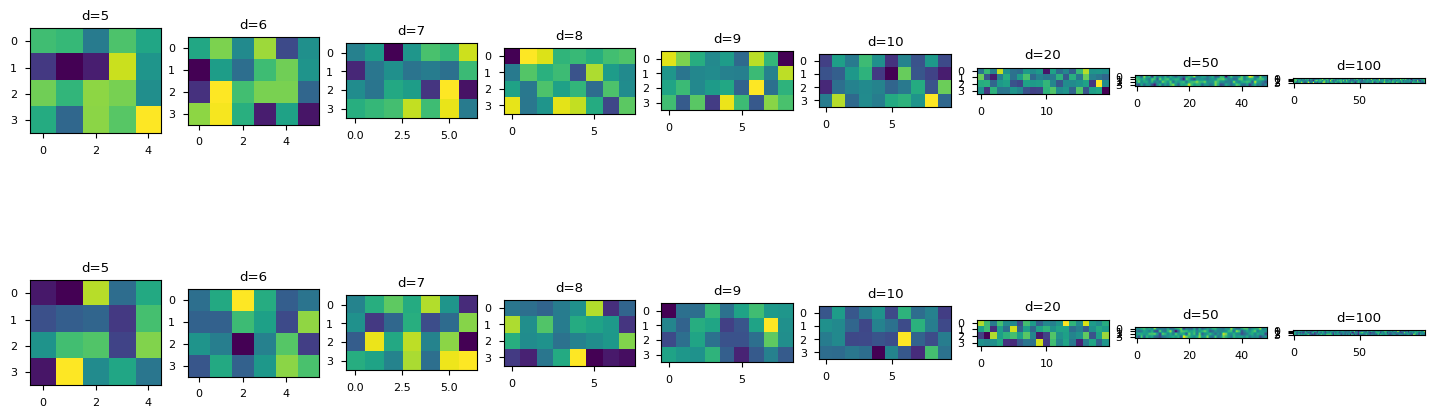

In [170]:
fig = plt.figure(figsize=(18,6))

embed_dim = [5, 6, 7, 8, 9, 10, 20, 50, 100]

embed_matrix_a = {}
embed_matrix_b = {} 

for i, dim_i in enumerate(embed_dim):
    
    proj_matrix = random_projection(4, dim_i)
    ax = fig.add_subplot(2, len(embed_dim), i+1)
    print(f'Embed Dim d = {dim_i:d}')
    embed_matrix_a[dim_i]=proj_matrix
    ax.imshow(proj_matrix.T)
    ax.set_title(f"d={dim_i:d}")
    ax.set_yticks(range(4))
    
    proj_matrix = random_projection(4, dim_i)
    ax = fig.add_subplot(2, len(embed_dim), i+1+len(embed_dim))
    print(f'Embed Dim d = {dim_i:d}')
    embed_matrix_b[dim_i]=proj_matrix
    ax.imshow(proj_matrix.T)
    ax.set_title(f"d={dim_i:d}")
    ax.set_yticks(range(4))
    

plt.savefig('Tori_proj.jpg')
plt.show()

In [192]:
# ========= Initializations and tori equation definitions =========
les_dist = {key: np.zeros((ITER_NUM, len(embed_dim))) for key in DICT_KEYS}
imd_ours = {key: np.zeros((ITER_NUM, len(embed_dim))) for key in DICT_KEYS}

for ite in range(ITER_NUM):
    print(f'Running iteration number {ite}')

    for i, dim_i in enumerate(embed_dim):
        print(f'Computing embedding dim = {dim_i:d}')

        # -------------- Generate tori data --------------
        data_2d_tor= tori_2d_gen(1)
        data_3d_tor = tori_3d_gen(1)
        
        data_2d_tor_a = np.dot(embed_matrix_a[dim_i][:,:3], data_2d_tor)
        data_2d_tor_b = np.dot(embed_matrix_b[dim_i][:,:3], data_2d_tor)
        data_3d_tor_a = np.dot(embed_matrix_a[dim_i], data_3d_tor)
        data_3d_tor_b = np.dot(embed_matrix_b[dim_i], data_3d_tor)
        
        # ---- Computing dataset descriptors and distances ----
        print('Computing LES descriptors and distances')
        les_desc_2d_tor_a = les_desc_comp(data_2d_tor_a.T, SIGMA, NEV, GAMMA)
        les_desc_2d_tor_b = les_desc_comp(data_2d_tor_b.T, SIGMA, NEV, GAMMA)
        
        les_desc_3d_tor_a = les_desc_comp(data_3d_tor_a.T, SIGMA, NEV, GAMMA)
        les_desc_3d_tor_b = les_desc_comp(data_3d_tor_b.T, SIGMA, NEV, GAMMA)

        les_dist['t2D_2D'][ite, i] = les_dist_comp(les_desc_2d_tor_a, les_desc_2d_tor_b)
        les_dist['t3D_3D'][ite, i] = les_dist_comp(les_desc_3d_tor_a, les_desc_3d_tor_b)
        
        # ---- Computing dataset descriptors and distances ----
        print('Computing IMD_OURS descriptors and distances')
        ALG_DIST = CompareIMDOurApproach(GAMMA, ITER_NUM, R_RATIOS, DICT_KEYS)
        
        imd_ours_desc_2d_tor_a = ALG_DIST._comp_desc(les_desc_2d_tor_a)
        imd_ours_desc_2d_tor_b = ALG_DIST._comp_desc(les_desc_2d_tor_b)
        
        imd_ours_desc_3d_tor_a = ALG_DIST._comp_desc(les_desc_3d_tor_a)
        imd_ours_desc_3d_tor_b = ALG_DIST._comp_desc(les_desc_3d_tor_b)

        imd_ours['t2D_2D'][ite, i] = ALG_DIST._comp_dist(imd_ours_desc_2d_tor_a, imd_ours_desc_2d_tor_b)
        imd_ours['t3D_3D'][ite, i] = ALG_DIST._comp_dist(imd_ours_desc_3d_tor_a, imd_ours_desc_3d_tor_b)



Running iteration number 0
Computing embedding dim = 5
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 6
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 7
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 8
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 9
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 10
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 20
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 50
Computing LES descriptors and distances
Computing IMD_OURS descriptors and distances
Computing embedding dim = 100
Computing LES descriptors and distan

In [196]:
result = les_dist
# imd_ours, les_dist

dist_type_col = [] 
iter_col = [] 
noise_vars_col = [] 
dist_col = []
for dist_type in result.keys():
    dist_type_col.extend([dist_type] * (ITER_NUM * len(embed_dim)))
    for i in range(ITER_NUM): 
        iter_col.extend([i]*len(embed_dim))
        noise_vars_col.extend(embed_dim)
        dist_col.extend(result[dist_type][i])
        
result_df = pd.DataFrame(zip(dist_type_col, iter_col, noise_vars_col, dist_col), columns=["type", 'iter', 'embed_dim', 'dist']) 

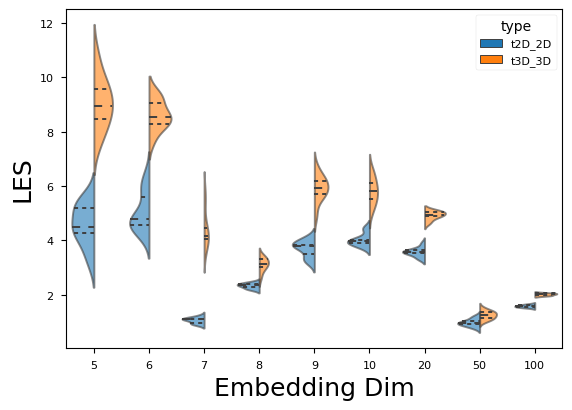

In [197]:
ax = sns.violinplot(data=result_df, x="embed_dim", y="dist", hue="type", split=True, gap=.1, inner="quart", saturation=1)
plt.setp(ax.collections, alpha=.6)
plt.xlabel("Embedding Dim", fontsize=18)

# plt.ylabel("IMD_OURS", fontsize=18)
# plt.savefig("IMD_OURS_dim.jpg")

plt.ylabel("LES", fontsize=18)
plt.savefig("LES_dim.jpg")

## Varying Embedding Dim 

[5, 6, 7, 8, 9, 10, 20, 50, 100]


Text(0.5, 0, 'Embedding Dim')

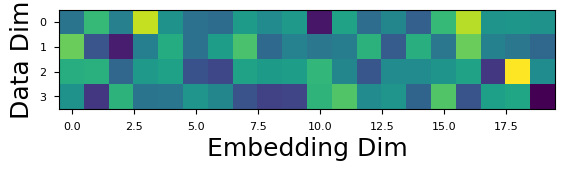

In [242]:
print(embed_dim)


dim_i = 20

shared_proj = False 
        
plt.imshow(embed_matrix_a[dim_i].T)
plt.yticks(range(4))
plt.ylabel("Data Dim", fontsize=18)
plt.xlabel("Embedding Dim", fontsize=18)

In [243]:
# ========= Initializations and tori equation definitions =========
DICT_KEYS = ['t2D_2DSc', 't2D_3D', 't2D_3DSc', 't3D_2DSc', 't3D_3DSc']
les_dist = {key: np.zeros((ITER_NUM, len(R_RATIOS))) for key in DICT_KEYS}

for ite in range(ITER_NUM):
    print(f'Running iteration number {ite}')

    for i, r_ratio in enumerate(R_RATIOS):
        # print(f'Computing radius ratio c = {r_ratio:.1f}')

        # -------------- Generate tori data --------------
        data_2d_tor = tori_2d_gen(1, NOISE_VAR=0.01)
        data_2d_tor_sc = tori_2d_gen(r_ratio, NOISE_VAR=0.01)
        data_3d_tor = tori_3d_gen(1,NOISE_VAR=0.01)
        data_3d_tor_sc = tori_3d_gen(r_ratio,NOISE_VAR=0.01)
        
        if shared_proj: 
            data_2d_tor = np.dot(embed_matrix_a[dim_i][:,:3], data_2d_tor)
            data_2d_tor_sc = np.dot(embed_matrix_a[dim_i][:,:3], data_2d_tor_sc)
            data_3d_tor = np.dot(embed_matrix_a[dim_i], data_3d_tor)
            data_3d_tor_sc = np.dot(embed_matrix_a[dim_i], data_3d_tor_sc)
        else: 
            data_2d_tor = np.dot(random_projection(3, dim_i), data_2d_tor)
            data_2d_tor_sc = np.dot(random_projection(3, dim_i), data_2d_tor_sc)
            data_3d_tor = np.dot(random_projection(4, dim_i), data_3d_tor)
            data_3d_tor_sc = np.dot(random_projection(4, dim_i), data_3d_tor_sc)
            

        # ---- Computing dataset descriptors and distances ----
        # print('Computing LES descriptors and distances')
        les_desc_2d_tor = les_desc_comp(data_2d_tor.T, SIGMA, NEV, GAMMA)
        les_desc_2d_tor_sc = les_desc_comp(data_2d_tor_sc.T, SIGMA, NEV, GAMMA)
        les_desc_3d_tor = les_desc_comp(data_3d_tor.T, SIGMA, NEV, GAMMA)
        les_desc_3d_tor_sc = les_desc_comp(data_3d_tor_sc.T, SIGMA, NEV, GAMMA)

        les_dist['t2D_2DSc'][ite, i] = les_dist_comp(les_desc_2d_tor, les_desc_2d_tor_sc)
        les_dist['t2D_3D'][ite, i] = les_dist_comp(les_desc_2d_tor, les_desc_3d_tor)
        les_dist['t2D_3DSc'][ite, i] = les_dist_comp(les_desc_2d_tor, les_desc_3d_tor_sc)
        les_dist['t3D_2DSc'][ite, i] = les_dist_comp(les_desc_3d_tor, les_desc_2d_tor_sc)
        les_dist['t3D_3DSc'][ite, i] = les_dist_comp(les_desc_3d_tor, les_desc_3d_tor_sc)

        for alg in algs_dists:
            # print('Computing ' + alg.upper() + ' descriptors')
            if alg == 'imd_ours':
                algs_dists[alg].comp_all_tori_dists(ite, i, les_desc_2d_tor, les_desc_2d_tor_sc, les_desc_3d_tor,
                                                    les_desc_3d_tor_sc)
            else:
                algs_dists[alg].comp_all_tori_dists(ite, i, data_2d_tor.T, data_2d_tor_sc.T, data_3d_tor.T,
                                                    data_3d_tor_sc.T)


Running iteration number 0
Running iteration number 1
Running iteration number 2
Running iteration number 3
Running iteration number 4
Running iteration number 5
Running iteration number 6
Running iteration number 7
Running iteration number 8
Running iteration number 9


/tmp/ipykernel_11816/288970099.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


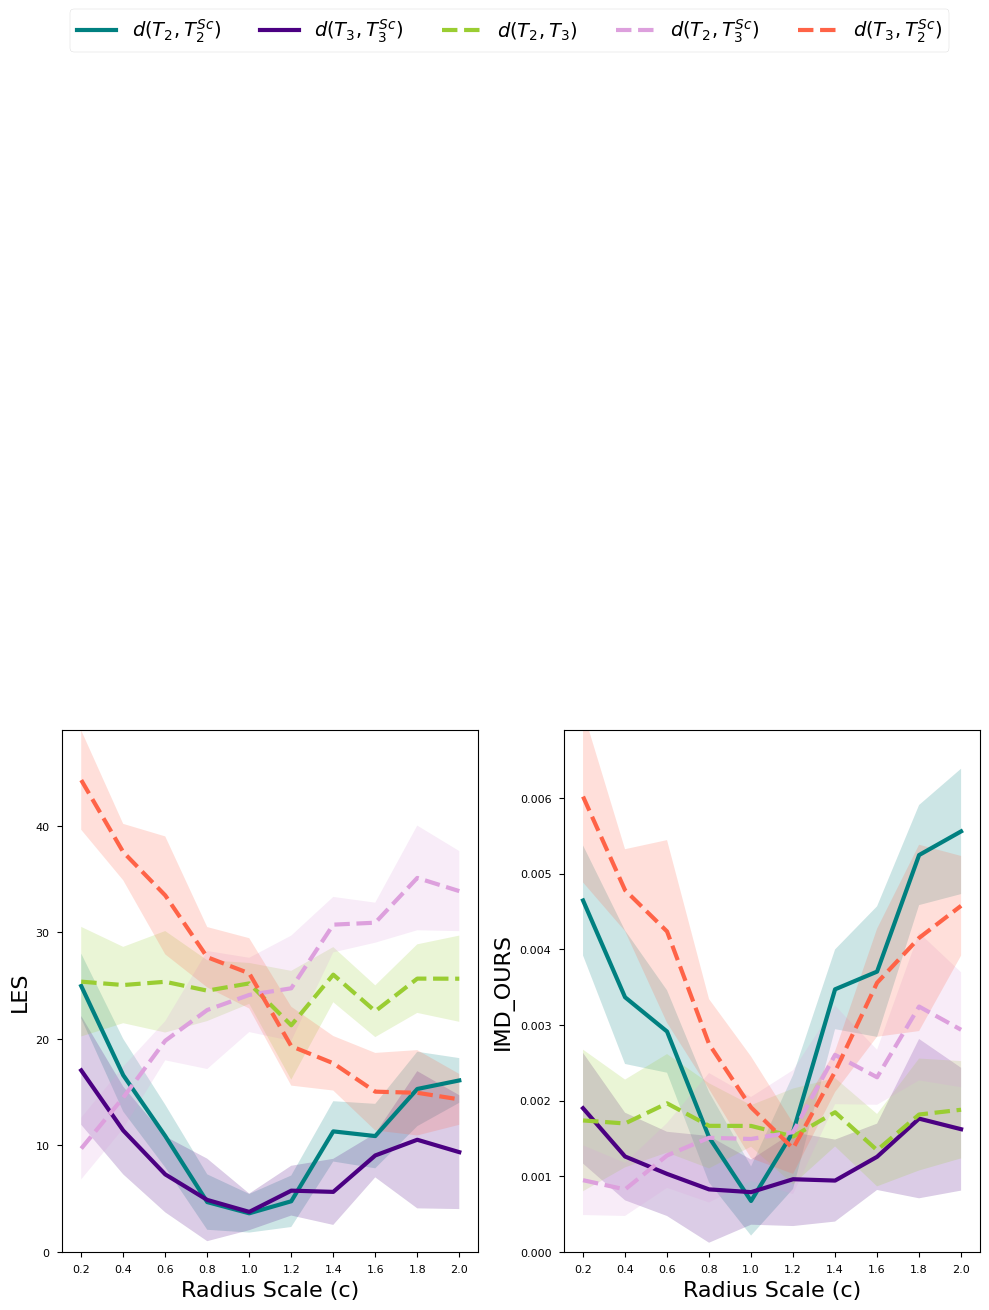

In [244]:
# ========================== Plot display ==========================
plt.style.use('seaborn-paper')
line_width = 3
alpha_val = 0.2


def create_distance_plt(var, ylabel='', xlabel=''):
    plt.plot(R_RATIOS, np.mean(var['t2D_2DSc'], axis=0), '-', color='teal', linewidth=line_width,
             label="$d(T_{2},T_{2}^{Sc})$")
    x, y, err = R_RATIOS, np.mean(var['t2D_2DSc'], axis=0), np.std(var['t2D_2DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='teal', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t3D_3DSc'], axis=0), '-', color='indigo', linewidth=line_width,
             label="$d(T_{3},T_{3}^{Sc})$")
    y, err = np.mean(var['t3D_3DSc'], axis=0), np.std(var['t3D_3DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='indigo', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t2D_3D'], axis=0), '--', color='yellowgreen', linewidth=line_width,
             label="$d(T_{2},T_{3})$")
    y, err = np.mean(var['t2D_3D'], axis=0), np.std(var['t2D_3D'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='yellowgreen', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t2D_3DSc'], axis=0), '--', color='plum', linewidth=line_width,
             label="$d(T_{2},T_{3}^{Sc})$")
    y, err = np.mean(var['t2D_3DSc'], axis=0), np.std(var['t2D_3DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='plum', linewidth=0)
    plt.plot(R_RATIOS, np.mean(var['t3D_2DSc'], axis=0), '--', color='tomato', linewidth=line_width,
             label="$d(T_{3},T_{2}^{Sc})$")
    y, err = np.mean(var['t3D_2DSc'], axis=0), np.std(var['t3D_2DSc'], axis=0)
    plt.fill_between(x, y - err, y + err, alpha=alpha_val, facecolor='tomato', linewidth=0)

    plt.ylim(bottom=0)
    plt.xticks(R_RATIOS, [ f"{r_ratio:.1f}" for r_ratio in R_RATIOS])
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)


anum = len(algs_dists) + 1
if anum <= 4:
    sbplt_rc = [1, anum]
else:
    sbplt_rc = [2, int(np.ceil(anum/2))]

fig = plt.figure(figsize=[10, 6])
plt.subplot(sbplt_rc[0], sbplt_rc[1], 1)
create_distance_plt(les_dist, ylabel='LES', xlabel='Radius Scale (c)')
plt.ylim([0, 49])
for i, alg in enumerate(algs_dists):
    plt.subplot(sbplt_rc[0], sbplt_rc[1], i+2)
    create_distance_plt(algs_dists[alg].all_distances, ylabel=alg.upper(), xlabel='Radius Scale (c)')
    if alg.upper() == "IMD_OURS":
        plt.ylim([0, 0.0069])

# plt.legend(framealpha=1, frameon=True, handlelength=2.5)
fig.tight_layout()
legendid = plt.legend(framealpha=1, frameon=True, loc='upper right', bbox_to_anchor=(0.95, 2.4), fontsize=14, labelspacing=0.1, handlelength=2, ncol=5)
plt.savefig(f'Tori_embed_{dim_i}d_independent.jpg')
plt.show()